In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.transform import Rotation

import collections
from types import SimpleNamespace

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / ccsds.GreedyBytes
)

date_format = mdates.DateFormatter('%H:%M')
date_format_sec = mdates.DateFormatter('%H:%M:%S')

In [2]:
frames = np.fromfile('hmap_frames_nrz.u8', 'uint8').reshape(-1, 5*223-2)
frames.shape

(5768, 1113)

## AOS frames

Frames are AOS frames using spacecraft ID `0xd6` (assigned to [LunaH-Map in SANA registry](https://sanaregistry.org/r/spacecraftid/records/14601)). Virtual channels 2 and 63 (OID) are in use.

In [3]:
aos = [ccsds.AOSPrimaryHeader.parse(f) for f in frames]
scid = [a.spacecraft_id for a in aos]
vcid = np.array([a.virtual_channel_id for a in aos])
vcfc = np.array([a.virtual_channel_frame_count for a in aos])
aos[:5]

[Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=504, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=505, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=506, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=507, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=508, replay_flag=False, vc_frame_count_usage_flag=

In [4]:
collections.Counter(scid)

Counter({214: 5768})

In [5]:
collections.Counter(vcid)

Counter({63: 3220, 2: 2548})

In [6]:
vc_seq = {vc: None for vc in set(vcid)}
master_counter = np.empty(frames.shape[0], 'int')
for j, a in enumerate(aos):
    vc = a.virtual_channel_id
    cnt = a.virtual_channel_frame_count
    if vc_seq[vc] is None:
        vc_seq[vc] = cnt
        incr = 1
    else:
        incr = cnt - vc_seq[vc]
        vc_seq[vc] = cnt
    if j == 0:
        m = 0
    else:
        m = incr + master_counter[j - 1]
    master_counter[j] = m

In [7]:
lost_frames = np.sum(np.diff(master_counter) - 1)
lost_frames

9

In [8]:
frame_duration = (5 * 8 * 223 + 4 + 32) * 2 / 255.1e3
frame_duration

0.0702156017248138

In [9]:
t_start = np.datetime64('2022-11-16T15:16:06.142')
t_frame = t_start + (frame_duration * 1e9 * master_counter) * np.timedelta64(1, 'ns')

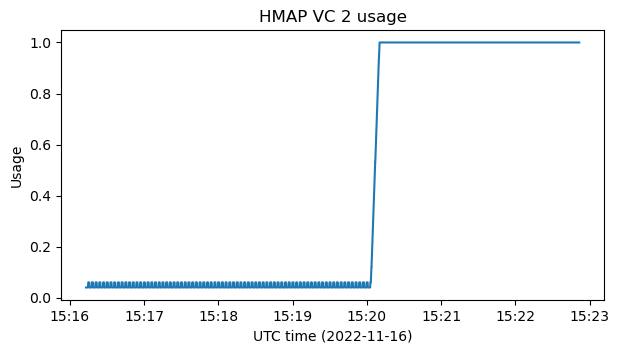

In [10]:
Navg = 100
vcid2_usage = np.convolve(vcid == 2, np.ones(Navg)/Navg)[Navg-1:-Navg+1]
plt.plot(t_frame[Navg-1:], vcid2_usage)
plt.title('HMAP VC 2 usage')
plt.ylabel('Usage')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format)

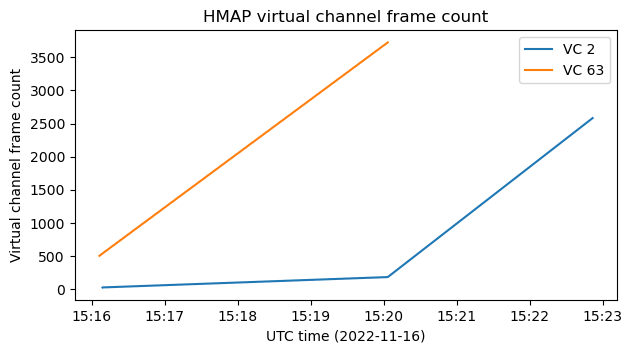

In [11]:
for v in sorted(set(vcid)):
    plt.plot(t_frame[vcid == v], vcfc[vcid == v], label=f'VC {v}')
plt.legend()
plt.title('HMAP virtual channel frame count')
plt.xlabel('UTC time (2022-11-16)')
plt.ylabel('Virtual channel frame count')
plt.gca().xaxis.set_major_formatter(date_format)

In [12]:
vcfc[vcid == 2]

array([  26,   27,   28, ..., 2580, 2581, 2582])

## VC 2

In virtual channel 2, APIDs 66, 1090 and 2047 (idle APID) are in use. Before VC 2 starts being used at full rate, APIDs 66 and 2047 are used in the same way as in the bi-phase-L (lower rate) recording. After VC 2 starts being used at full rate, most of the bandwidth is used for APID 1090, which seems to contain high-rate telemetry. APID 2047 disappears, and the rate of APID 66 also increases somewhat.

The Space Packets in APIDs 66 and 1090 both have 1501 bytes, but they contain different data.

In [13]:
frame_loss_vc2 = np.sum(np.diff(vcfc[vcid == 2]) - 1)
frame_loss_vc2

9

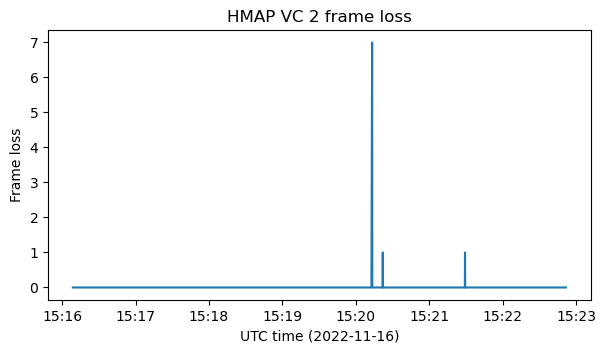

In [14]:
plt.plot(t_frame[vcid == 2][1:], np.diff(vcfc[vcid == 2]) - 1)
plt.title('HMAP VC 2 frame loss')
plt.ylabel('Frame loss')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format)

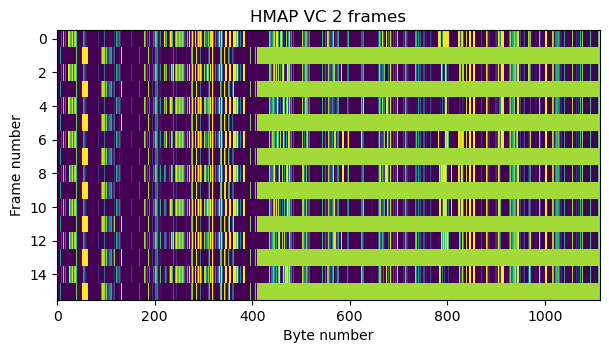

In [15]:
plt.imshow(frames[vcid == 2][:16], aspect='auto', interpolation='none')
plt.title('HMAP VC 2 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

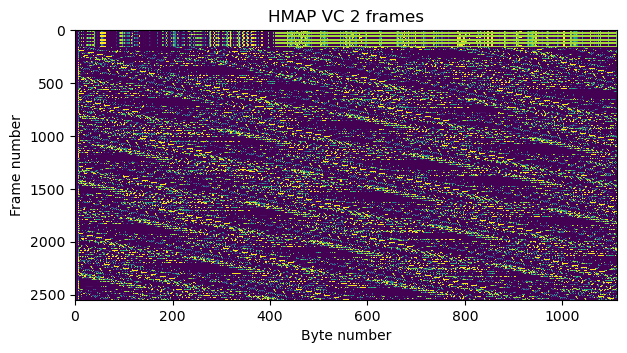

In [16]:
plt.imshow(frames[vcid == 2][:], aspect='auto', interpolation='none')
plt.title('HMAP VC 2 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [17]:
frame = AOSFrame.parse(frames[0])

In [18]:
frame.insert_zone = Container
frame.insert_zone.timestamp = t_frame[0]

In [19]:
frame.insert_zone.timestamp

numpy.datetime64('2022-11-16T15:16:06.142000000')

In [20]:
frames_vc2 = []
for f, t in zip(frames[vcid == 2], t_frame[vcid == 2]):
    frame = AOSFrame.parse(f)
    # Fake that the timestamp came into the AOS insert zone,
    # since the Space Packet defragmenter gets the timestamps from there.
    setattr(frame, 'insert_zone', SimpleNamespace())
    setattr(frame.insert_zone, 'timestamp', t)
    frames_vc2.append(frame)
packets = list(ccsds.extract_space_packets(frames_vc2, 214, 2, get_timestamps=True))

/home/daniel/jupyter_notebooks/ArtemisI/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 214 VC 2] Broken stream. Last frame count 318, current frame count 326
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/jupyter_notebooks/ArtemisI/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 214 VC 2] Broken stream. Last frame count 448, current frame count 450
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/jupyter_notebooks/ArtemisI/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 214 VC 2] Broken stream. Last frame count 1405, current frame count 1407
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame 

In [21]:
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in packets]
packet_timestamps = np.array([p[1] for p in packets])

In [22]:
packet_headers[:4]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=66, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1494),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=702),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=66, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1494),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=702)]

In [23]:
packet_headers[-4:]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1090, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1494),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1090, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1494),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1090, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1494),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1090, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1494)]

In [24]:
apid_packet = np.array([p.APID for p in packet_headers])
apids = collections.Counter(apid_packet)
apids

Counter({66: 223, 2047: 79, 1090: 1613})

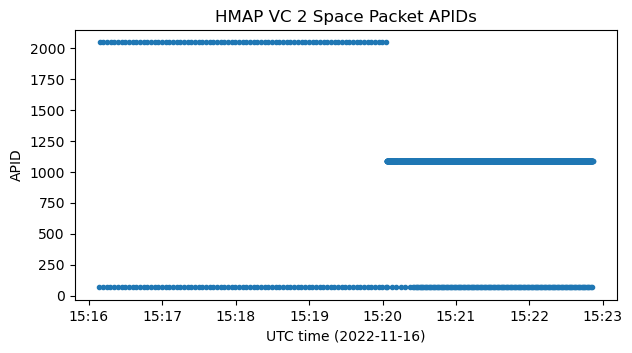

In [25]:
plt.plot(packet_timestamps, apid_packet, '.')
plt.title('HMAP VC 2 Space Packet APIDs')
plt.ylabel('APID')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format)

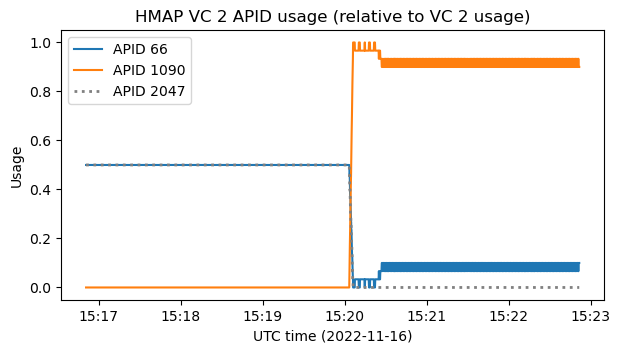

In [26]:
Navg = 30
for apid in sorted(apids):
    apid_usage = np.convolve(apid_packet == apid, np.ones(Navg)/Navg)[Navg-1:-Navg+1]
    extra = {'color': 'grey', 'linestyle': ':', 'linewidth': 2} if apid == 2047 else {}
    plt.plot(packet_timestamps[Navg-1:], apid_usage,
             label=f'APID {apid}', **extra)
plt.title('HMAP VC 2 APID usage (relative to VC 2 usage)')
plt.ylabel('Usage')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend();

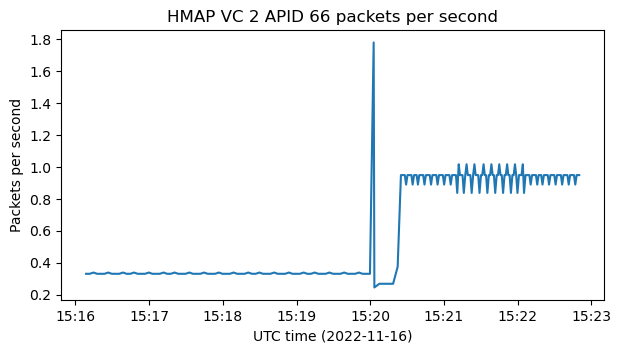

In [27]:
apid66_per_second = np.timedelta64(1, 's')/np.diff(packet_timestamps[apid_packet==66])
plt.plot(packet_timestamps[apid_packet==66][:-1], apid66_per_second)
plt.title('HMAP VC 2 APID 66 packets per second')
plt.ylabel('Packets per second')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format);

In [28]:
by_apid = {apid : [p for h,p in zip(packet_headers, packets)
                   if h.APID == apid] for apid in apids}

In [29]:
idle_packets = np.array([np.frombuffer(a[0], 'uint8') for a in by_apid[2047]])
np.all(idle_packets[:, ccsds.SpacePacketPrimaryHeader.sizeof():] == 0xdc)

True

In [30]:
np.all(idle_packets == idle_packets[0])

True

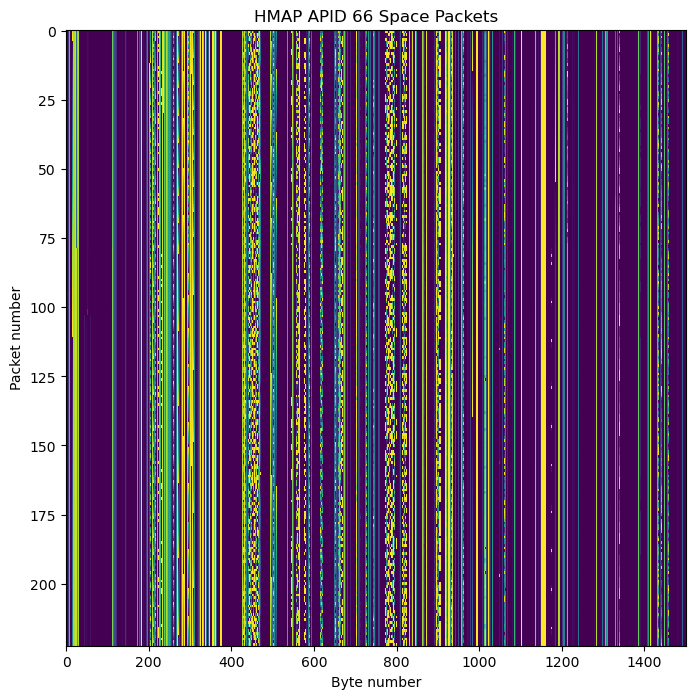

In [31]:
apid66 = np.array([np.frombuffer(a[0], 'uint8') for a in by_apid[66]])
plt.figure(figsize=(8, 8))
plt.imshow(apid66, aspect='auto', interpolation='none')
plt.title('HMAP APID 66 Space Packets')
plt.ylabel('Packet number')
plt.xlabel('Byte number');

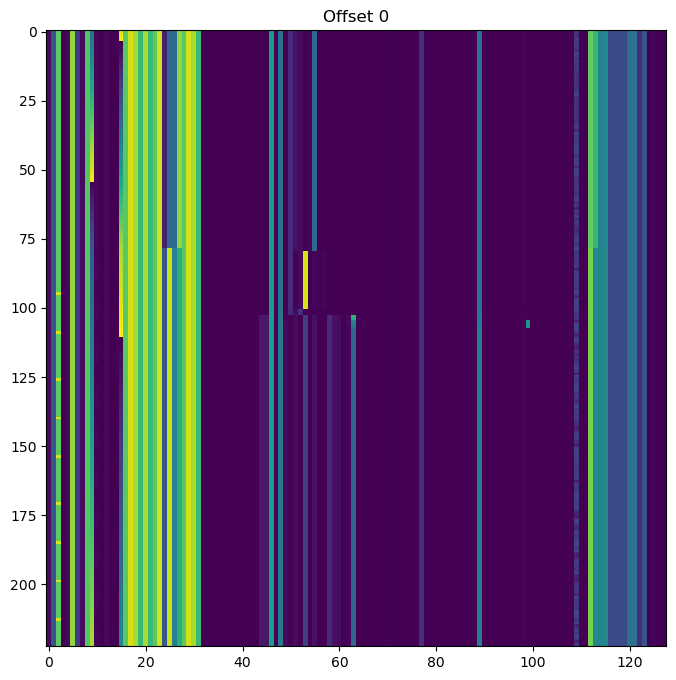

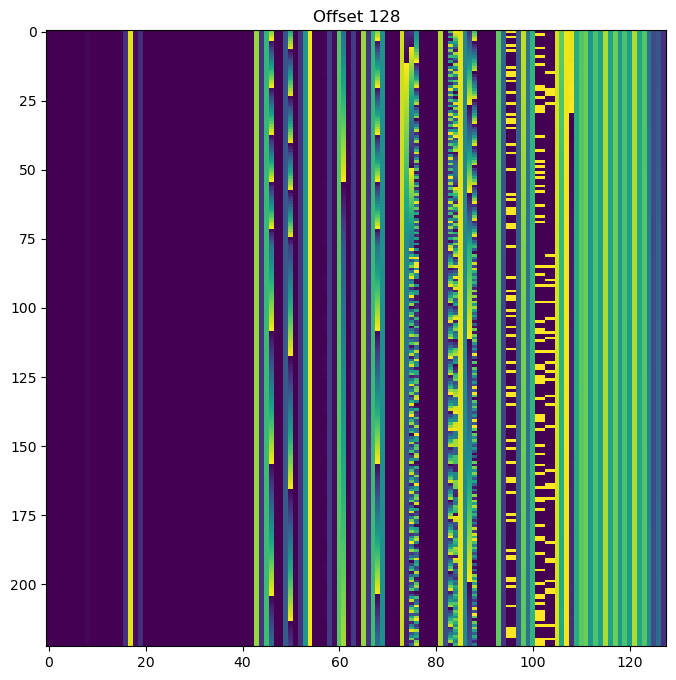

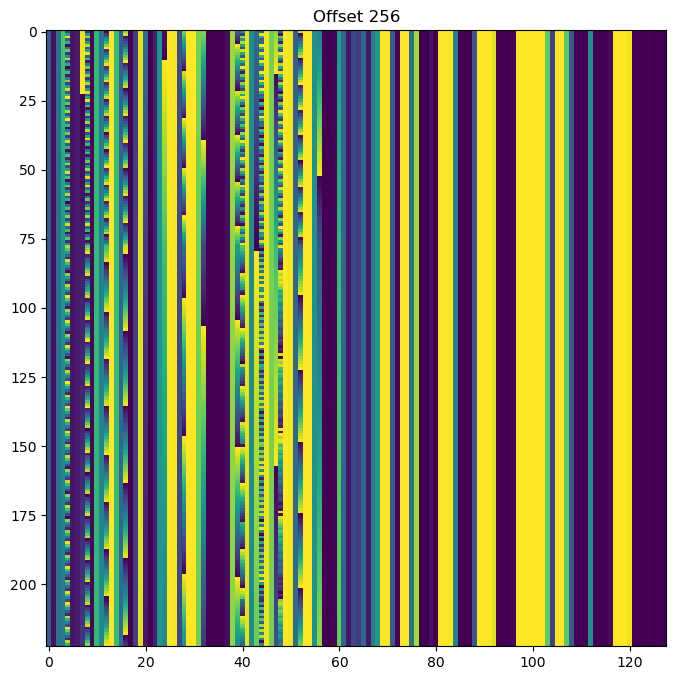

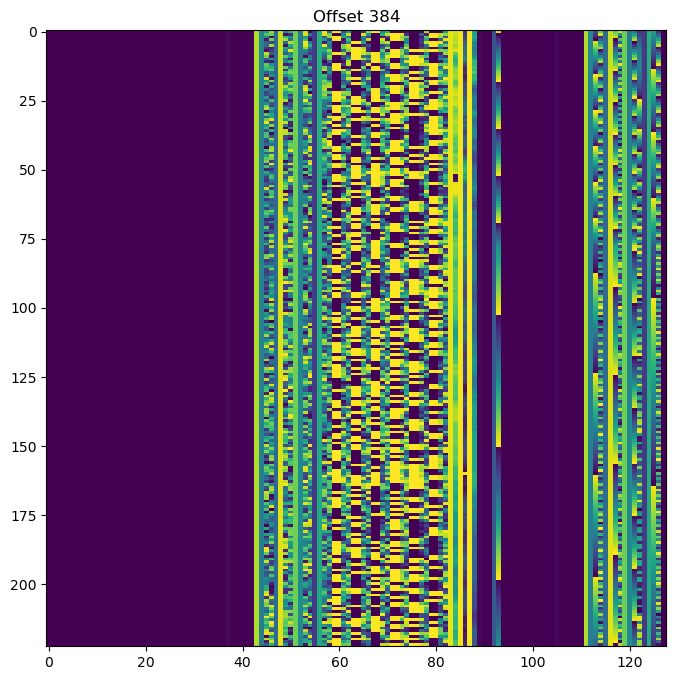

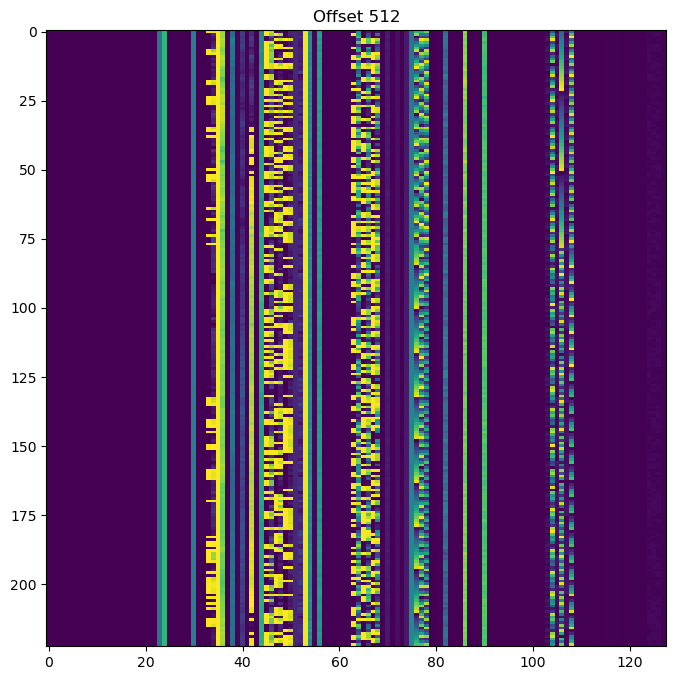

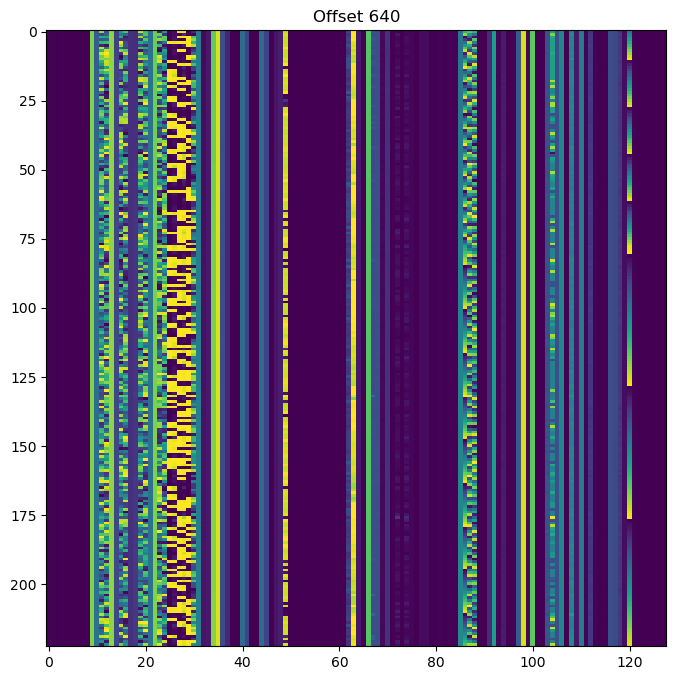

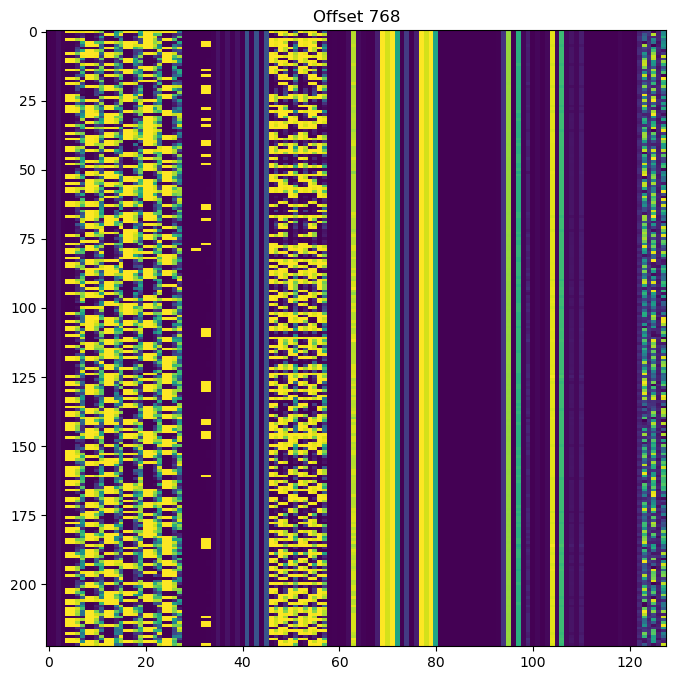

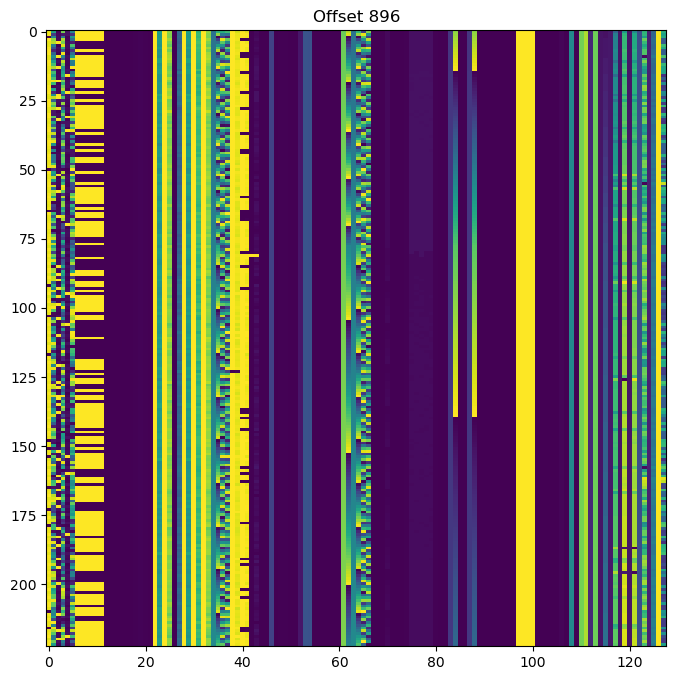

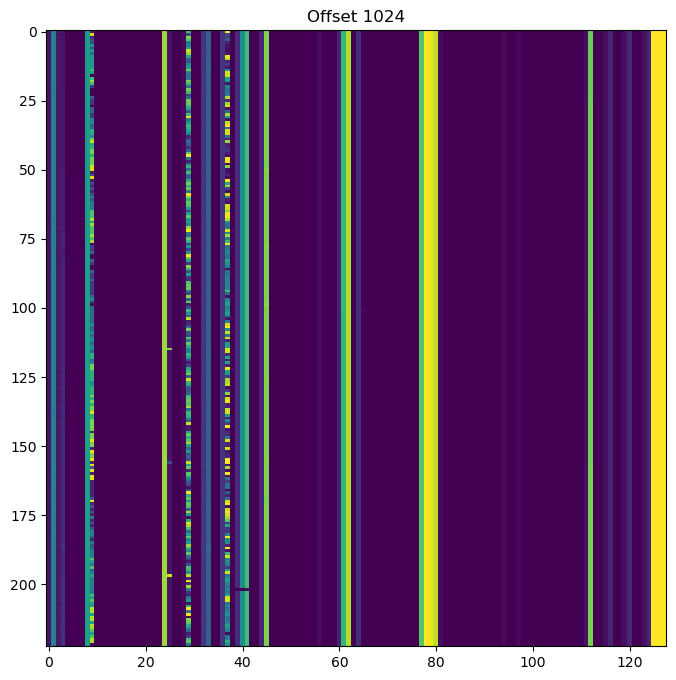

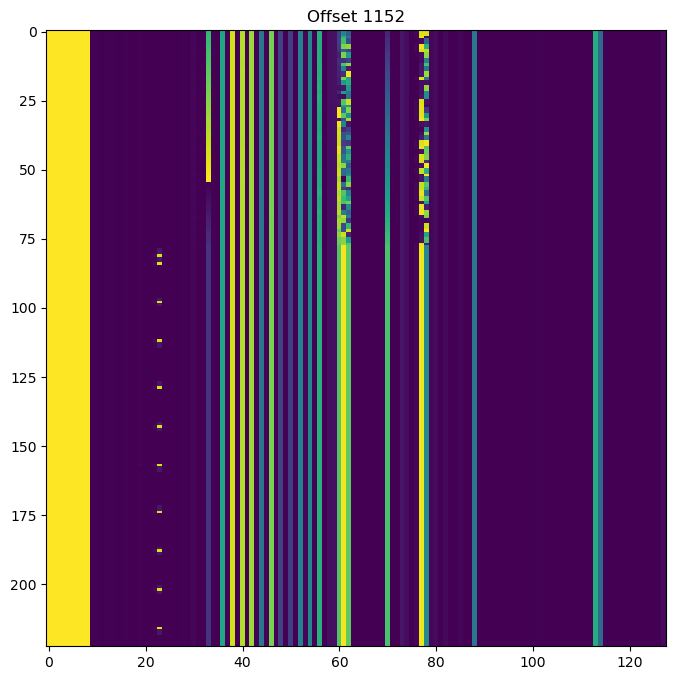

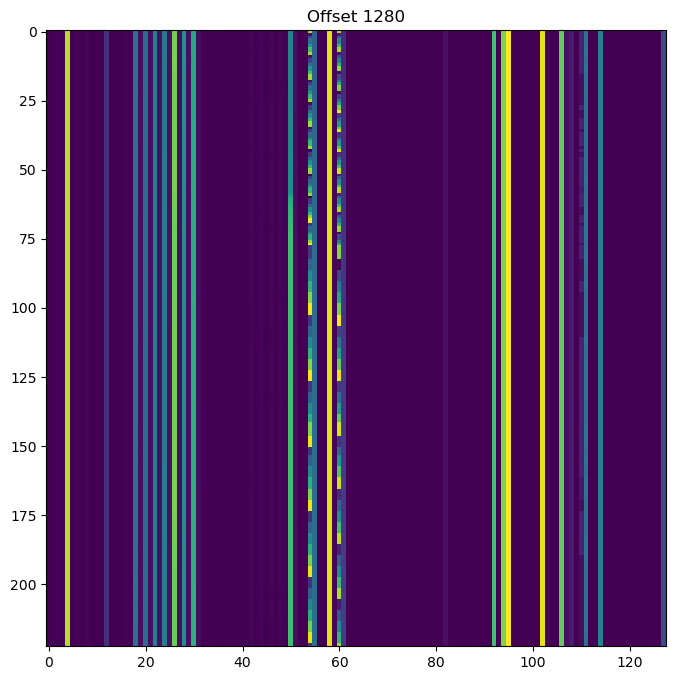

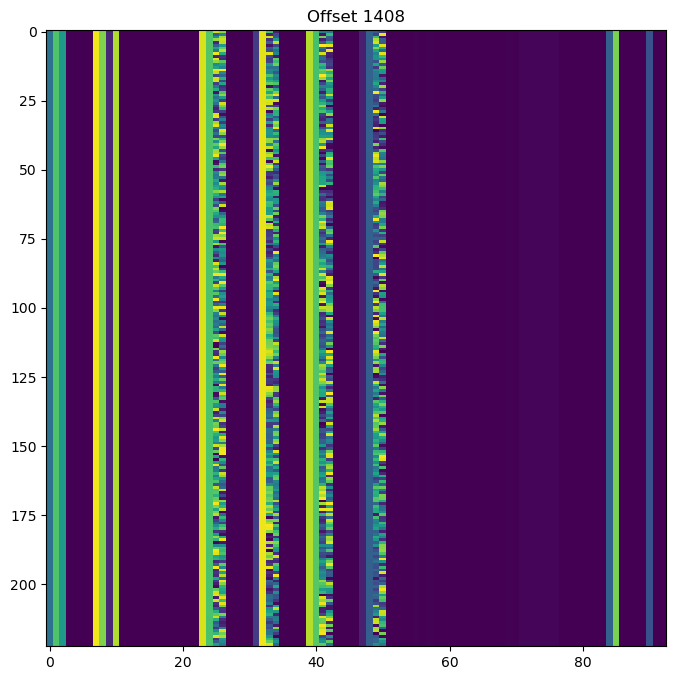

In [32]:
for j in range(12):
    plt.figure(figsize=(8, 8))
    plt.imshow(apid66[:, j*128:(j+1)*128], aspect='auto', interpolation='none')
    plt.title(f'Offset {j*128}')

These bytes contain a counter that increases by 1, 2, or 3.

In [33]:
np.diff(apid66[:, 8:10].view('uint16').byteswap().ravel())

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=uint16)

These bytes seem to contain quaternions as int32 using the scale factor 1e9. The quaternions change very slowly. It is not clear what they represent.

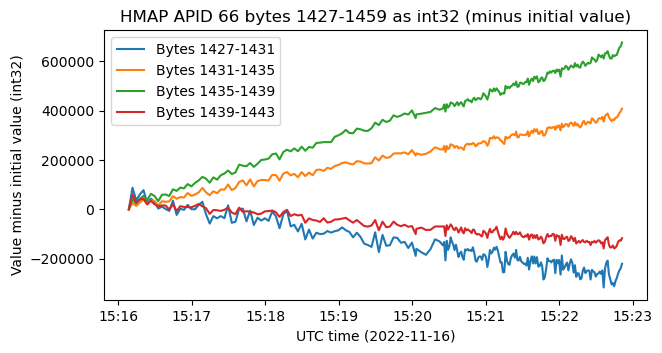

In [34]:
z = apid66[:, 1408+19:][:, :4*8].view('int32').byteswap()[:, 1::2]
plt.plot(packet_timestamps[apid_packet==66], z - z[0])
plt.title('HMAP APID 66 bytes 1427-1459 as int32 (minus initial value)')
plt.legend([f'Bytes {a}-{a+4}' for a in range(1427, 1459, 4)])
plt.ylabel('Value minus initial value (int32)')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format);

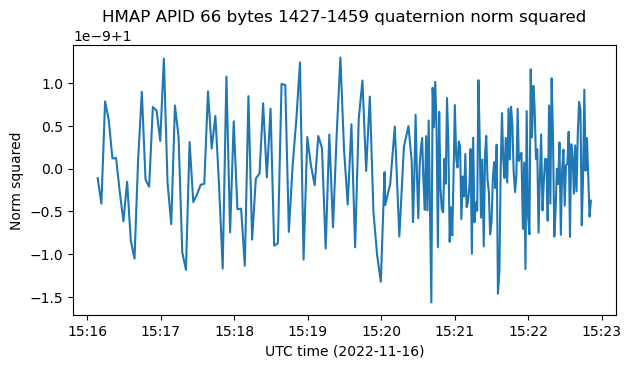

In [35]:
zscale = 1e9
z_float = z.astype('float') / zscale
plt.plot(packet_timestamps[apid_packet==66], np.sum(z_float**2, axis=1))
plt.title('HMAP APID 66 bytes 1427-1459 quaternion norm squared')
plt.ylabel('Norm squared')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format);

In [36]:
q = Rotation.from_quat(z_float[:, [1, 2, 3, 0]]) # scalar last format
H = q*q[0].inv()
V = H.as_quat()[:,:-1]
V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]

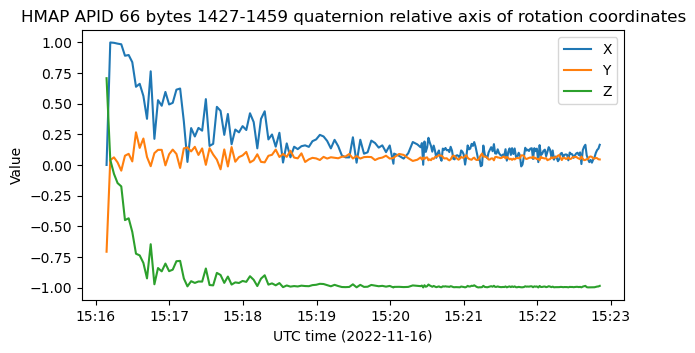

In [37]:
plt.plot(packet_timestamps[apid_packet==66], V)
plt.legend(['X', 'Y', 'Z'])
plt.title('HMAP APID 66 bytes 1427-1459 quaternion relative axis of rotation coordinates')
plt.ylabel('Value')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format);

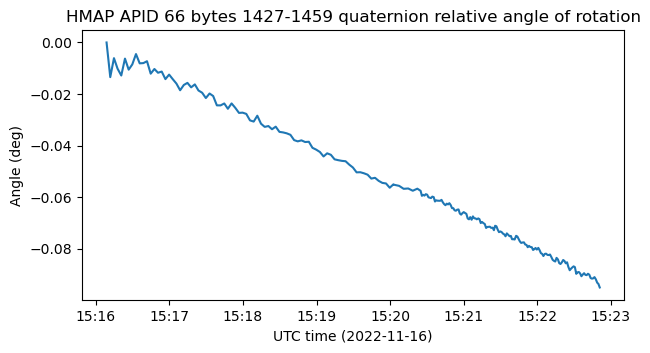

In [38]:
theta = 2 * np.arctan2(np.sqrt(np.sum(H.as_quat()[:,:-1]**2, axis = 1)), H.as_quat()[:,-1])
theta = (theta + np.pi) % (2 * np.pi) - np.pi
plt.plot(packet_timestamps[apid_packet==66], np.rad2deg(theta))
plt.title('HMAP APID 66 bytes 1427-1459 quaternion relative angle of rotation')
plt.ylabel('Angle (deg)')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format);

In [39]:
degrees_per_second = (
    np.rad2deg(theta[-1])
    / ((packet_timestamps[apid_packet==66][-1] - packet_timestamps[apid_packet==66][0])
       / np.timedelta64(1, 's')))
degrees_per_second

-0.00023613090803160377

In [40]:
revolution_period = 360 / np.abs(degrees_per_second)
revolution_period / (24 * 3600)

17.645579316152038

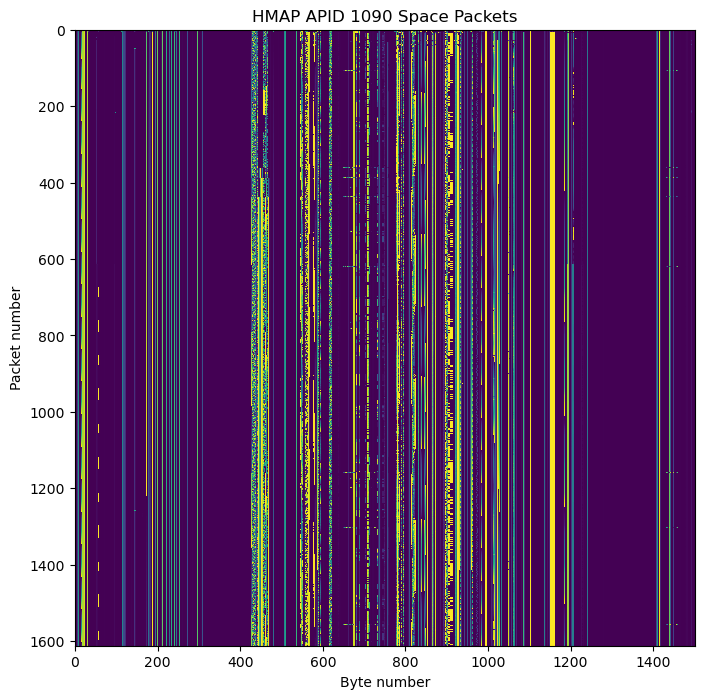

In [41]:
t_apid1090 = packet_timestamps[apid_packet == 1090]
apid1090 = np.array([np.frombuffer(a[0], 'uint8') for a in by_apid[1090]])
plt.figure(figsize=(8, 8))
plt.imshow(apid1090, aspect='auto', interpolation='none')
plt.title('HMAP APID 1090 Space Packets')
plt.ylabel('Packet number')
plt.xlabel('Byte number');

In [42]:
apid66.shape, apid1090.shape

((223, 1501), (1613, 1501))

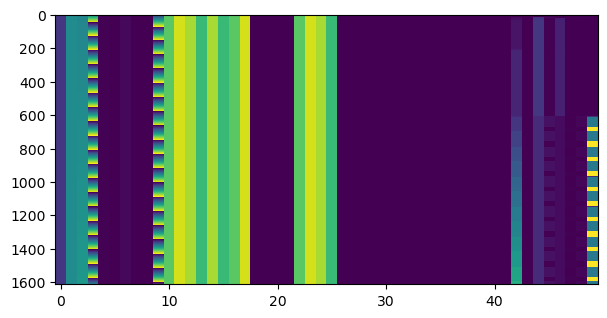

In [43]:
plt.imshow(apid1090[:, 6:][:, :50], aspect='auto', interpolation='none')

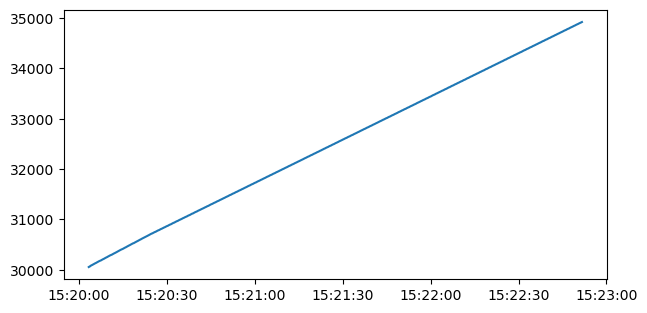

In [44]:
apid1090_counter = apid1090[:, 8:10].view('uint16').byteswap().ravel()
plt.plot(t_apid1090, apid1090_counter)

In [45]:
np.diff(apid1090_counter)

array([3, 3, 3, ..., 3, 3, 3], dtype=uint16)

In [46]:
apid1090[:, 6:6+6]

array([[ 40, 124, 117, 103,   4,   0],
       [ 40, 124, 117, 106,   4,   0],
       [ 40, 124, 117, 109,   4,   0],
       ...,
       [ 40, 124, 136, 100,   1,   0],
       [ 40, 124, 136, 103,   1,   0],
       [ 40, 124, 136, 106,   1,   0]], dtype=uint8)

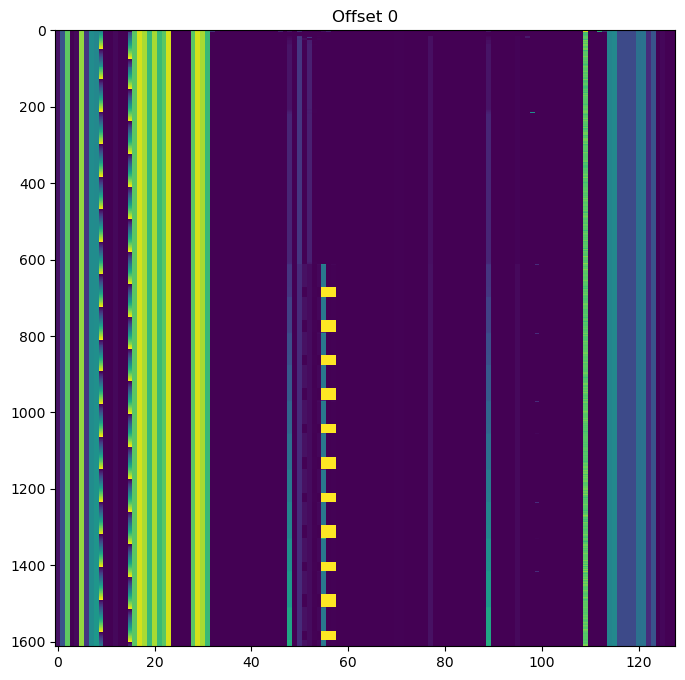

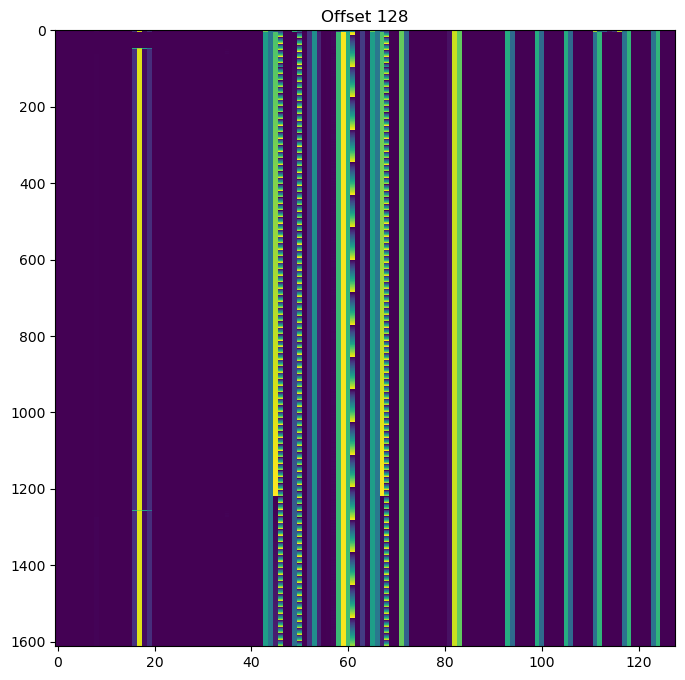

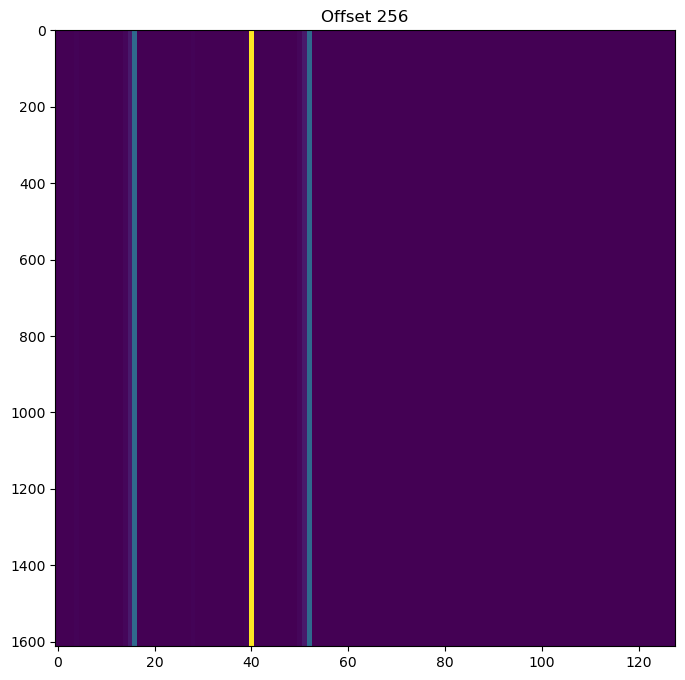

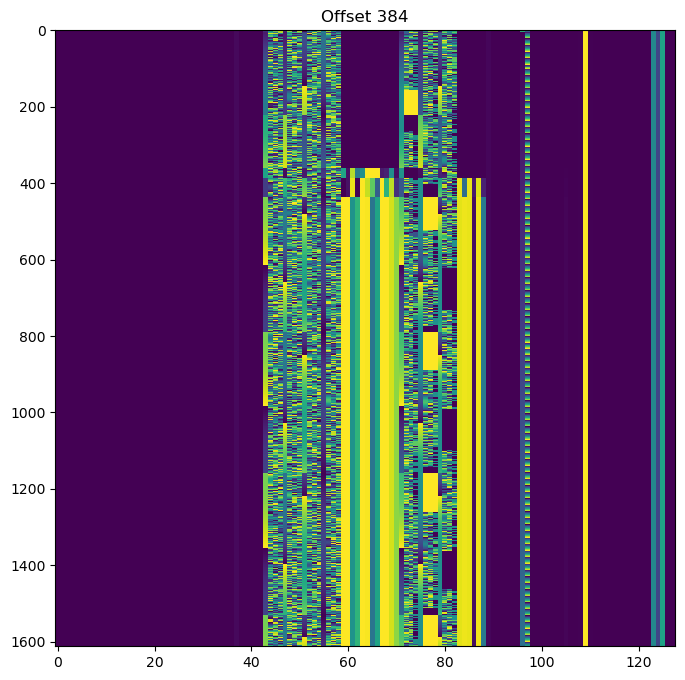

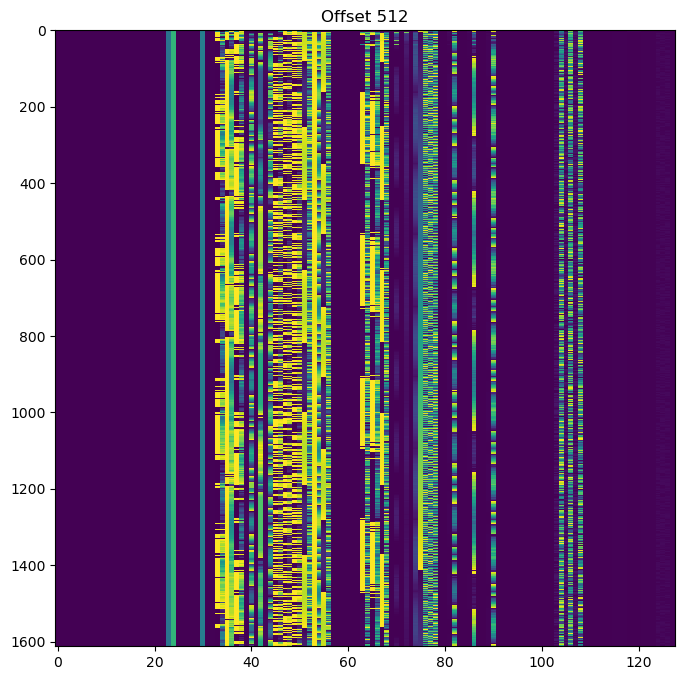

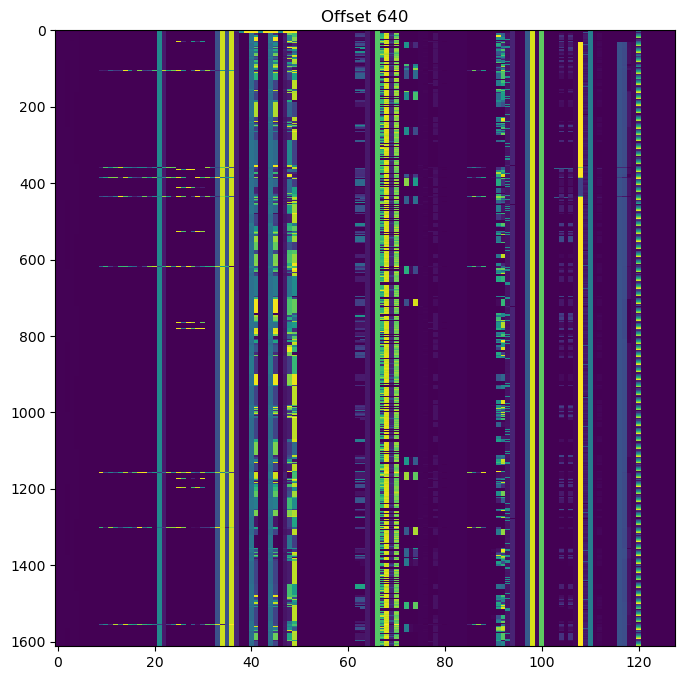

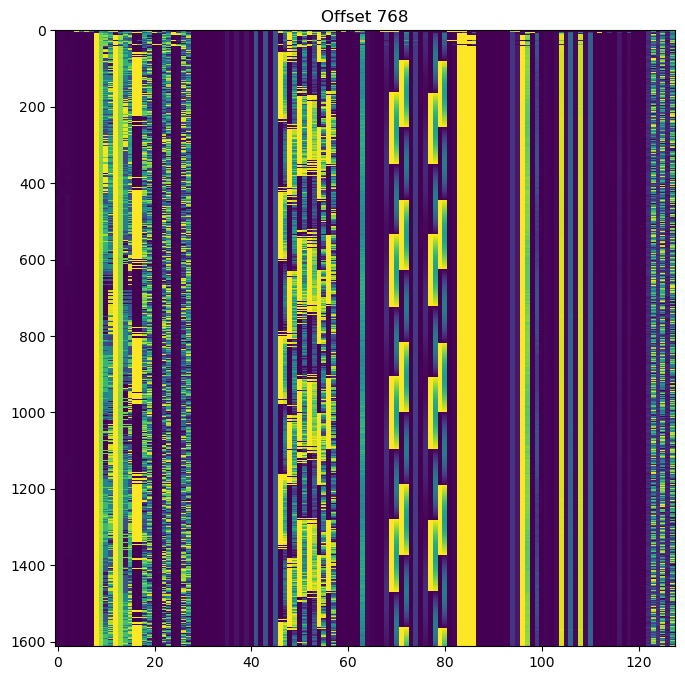

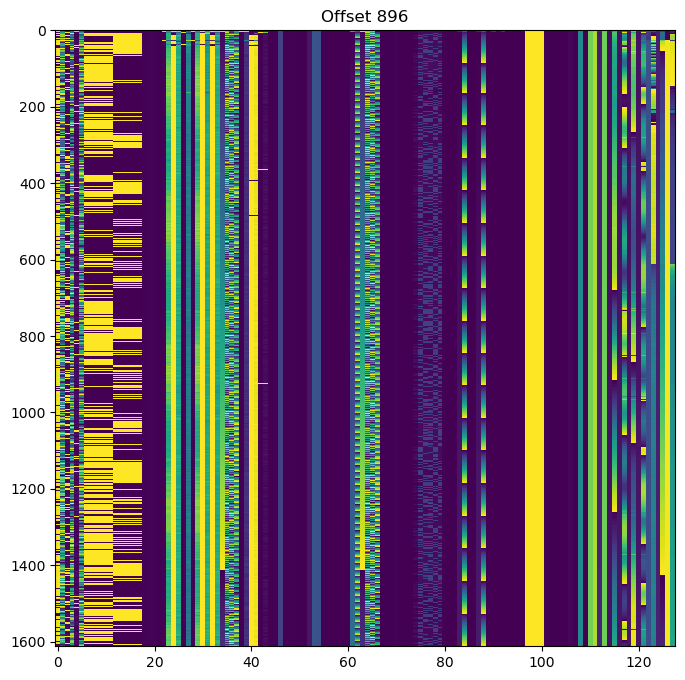

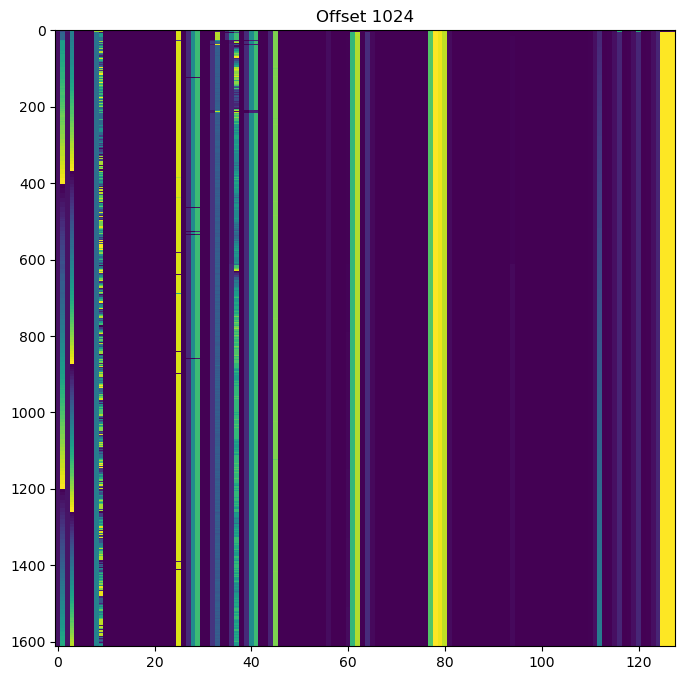

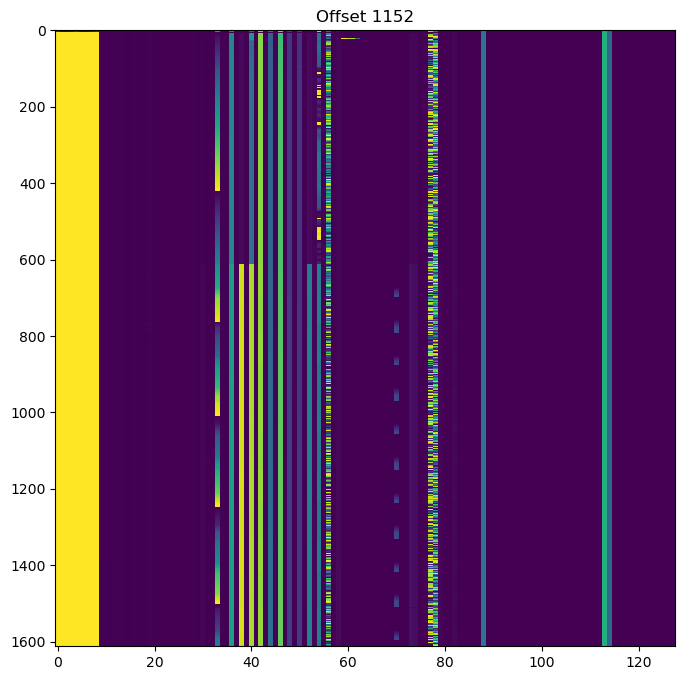

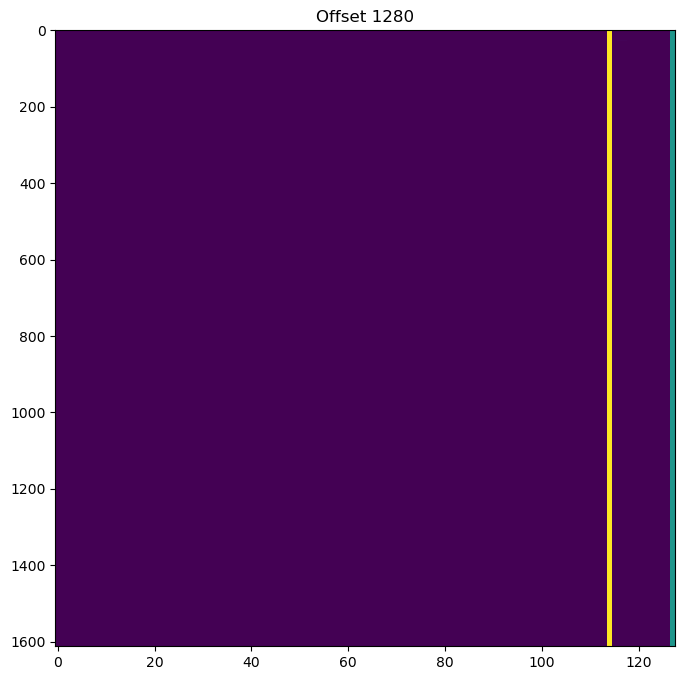

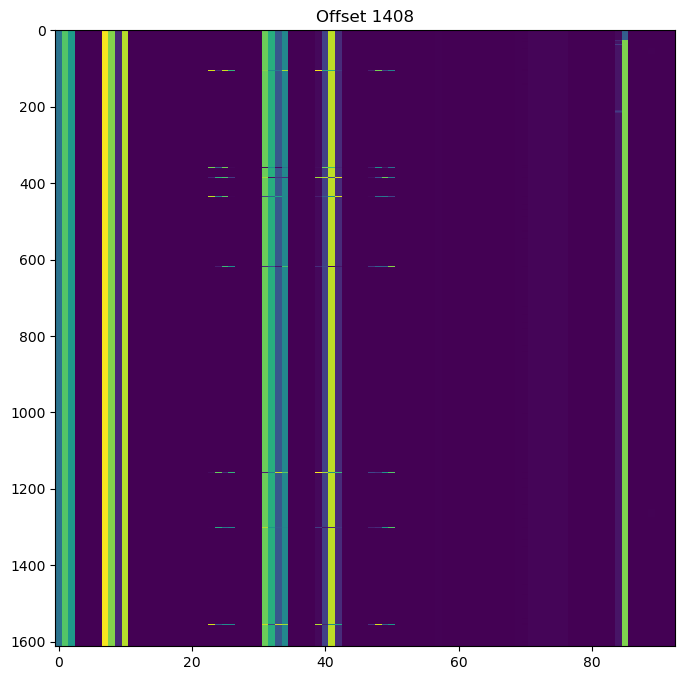

In [47]:
for j in range(12):
    plt.figure(figsize=(8, 8))
    plt.imshow(apid1090[:, j*128:(j+1)*128], aspect='auto', interpolation='none')
    plt.title(f'Offset {j*128}')

These bytes seem to contain quaternions as int32 using the scale factor 2e9. They describe a rotation around a constant axis, whose period matches the fading we see on the signal.

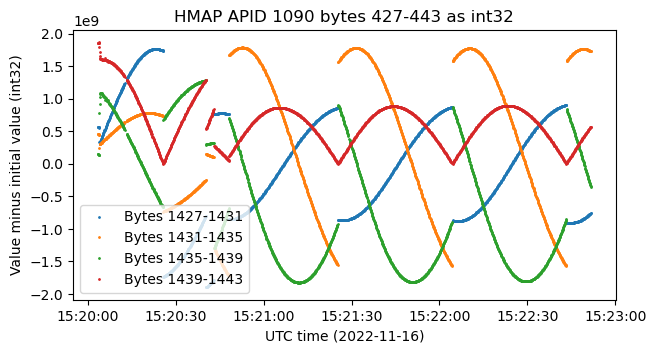

In [112]:
z = apid1090[:, 384+43:][:, :4*4].view('int32').byteswap()
plt.plot(t_apid1090, z, '.', markersize=2)
plt.title('HMAP APID 1090 bytes 427-443 as int32')
plt.legend([f'Bytes {a}-{a+4}' for a in range(1427, 1459, 4)])
plt.ylabel('Value minus initial value (int32)')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format_sec);

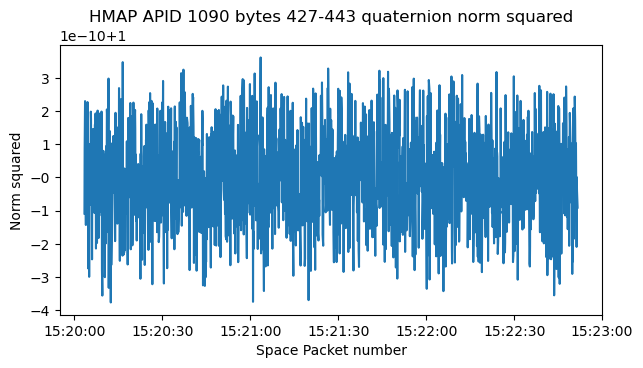

In [113]:
z_scale = 2e9
z_float = z.astype('float') / z_scale
z_norm = np.sqrt(np.sum(z_float**2, axis=1))
plt.plot(t_apid1090, z_norm)
plt.title('HMAP APID 1090 bytes 427-443 quaternion norm squared')
plt.xlabel('Space Packet number')
plt.ylabel('Norm squared')
plt.gca().xaxis.set_major_formatter(date_format_sec);

In [114]:
np.average(z_norm)

1.000000000000553

In [123]:
q = Rotation.from_quat(z_float[:, [1, 2, 3, 0]]) # scalar last format

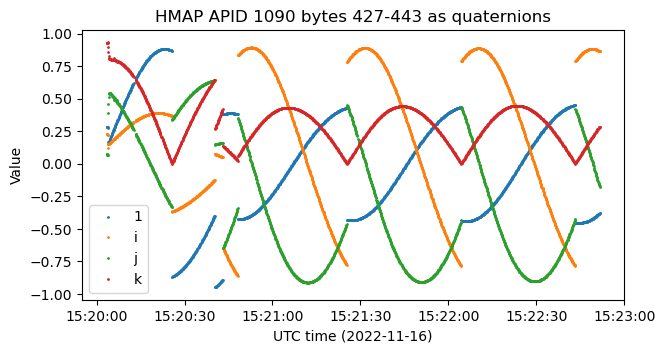

In [124]:
plt.plot(t_apid1090, z_float, '.', markersize=2)
plt.title('HMAP APID 1090 bytes 427-443 as quaternions')
plt.legend(['1', 'i', 'j', 'k'])
plt.ylabel('Value')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format_sec);

In [125]:
ref_instants = [100, 375, 400, 500]

H = [q*q[r].inv() for r in ref_instants]
V = np.array([h.as_quat()[:,:-1] for h in H])
V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]
W = V * np.sign(V[..., -1])[..., np.newaxis]

/tmp/ipykernel_494277/598686537.py:5: RuntimeWarning: invalid value encountered in divide
  V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]


In [126]:
[W[j][r + 10] for j, r in enumerate(ref_instants)]

[array([-0.21148269,  0.23852847,  0.9478287 ]),
 array([-0.22737197,  0.23691841,  0.94454839]),
 array([ 0.13508363, -0.04421411,  0.98984722]),
 array([-0.0537697 , -0.02149941,  0.99832189])]

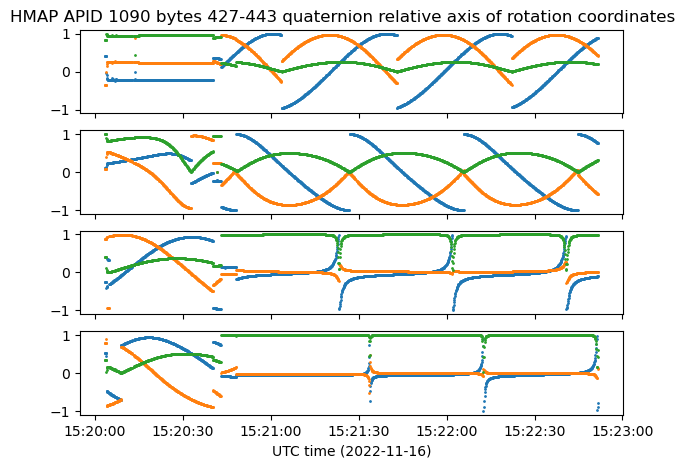

In [127]:
fig, axs = plt.subplots(len(ref_instants), sharex=True, sharey=True,
                        figsize=(7, 5))
for j in range(len(ref_instants)):
    axs[j].plot(t_apid1090, W[j], '.', markersize=2)
plt.suptitle('HMAP APID 1090 bytes 427-443 quaternion relative axis of rotation coordinates', y=0.92)
axs[-1].set_xlabel('UTC time (2022-11-16)')
axs[-1].xaxis.set_major_formatter(date_format_sec);

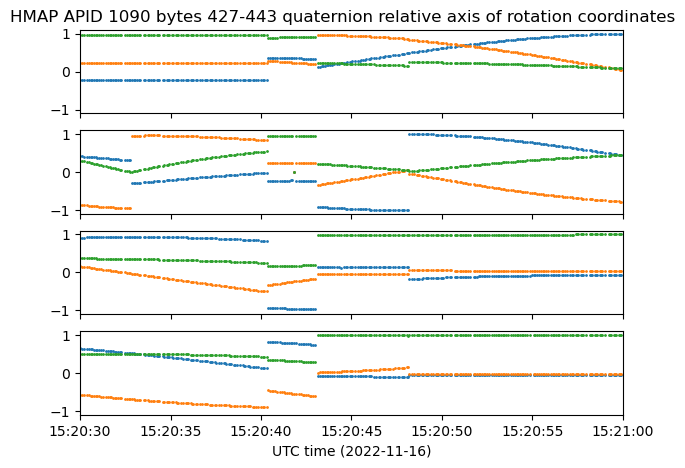

In [128]:
fig, axs = plt.subplots(len(ref_instants), sharex=True, sharey=True,
                        figsize=(7, 5))
for j in range(len(ref_instants)):
    axs[j].plot(t_apid1090, W[j], '.', markersize=2)
plt.xlim((np.datetime64('2022-11-16T15:20:30'), np.datetime64('2022-11-16T15:21:00')))
plt.suptitle('HMAP APID 1090 bytes 427-443 quaternion relative axis of rotation coordinates', y=0.92)
axs[-1].set_xlabel('UTC time (2022-11-16)')
axs[-1].xaxis.set_major_formatter(date_format_sec);

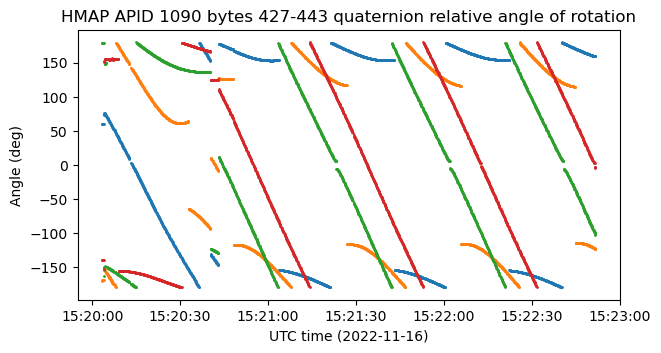

In [131]:
theta = np.array([2 * np.arctan2(np.sqrt(np.sum(h.as_quat()[:,:-1]**2, axis = 1)), h.as_quat()[:,-1])
                  for h in H])
theta *= np.sign(V[..., -1])
theta = (theta + np.pi) % (2*np.pi) - np.pi
plt.plot(t_apid1090, np.rad2deg(theta.T), '.', markersize=2)
plt.title('HMAP APID 1090 bytes 427-443 quaternion relative angle of rotation')
plt.ylabel('Angle (deg)')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format_sec);

In [132]:
theta_sel = slice(450, 1100)
theta_unwrap = theta[-1, theta_sel]
theta_unwrap = np.unwrap(theta_unwrap[~np.isnan(theta_unwrap)])
dtheta_rad_s = (
    (theta_unwrap[-1] - theta_unwrap[0])
    / ((t_apid1090[theta_sel.stop - 1] - t_apid1090[theta_sel.start]) / np.timedelta64(1, 's')))
dtheta_rpm = 60 / (2 * np.pi) * dtheta_rad_s
dtheta_rpm

-1.549883328427041

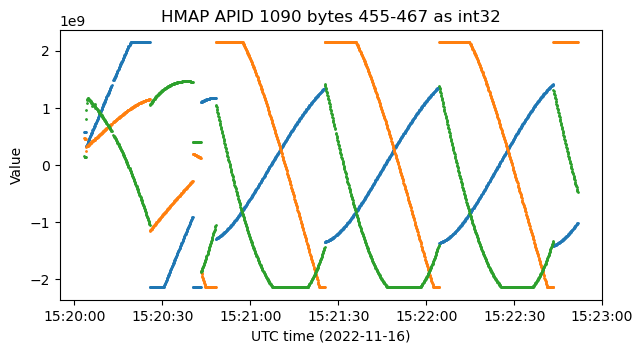

In [133]:
z2 = apid1090[:, 384+71:][:, :3*4].view('int32').byteswap()
plt.plot(t_apid1090, z2, '.', markersize=2)
plt.title('HMAP APID 1090 bytes 455-467 as int32')
plt.ylabel('Value')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format_sec);

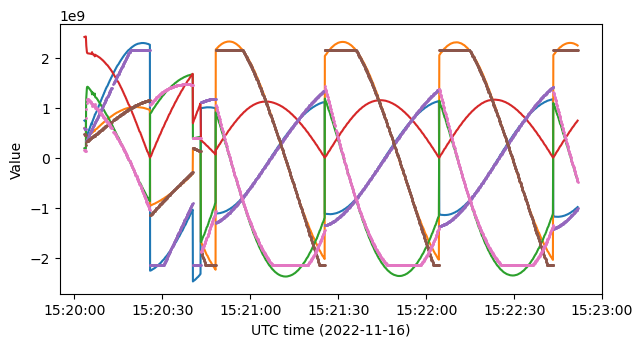

In [134]:
plt.plot(t_apid1090, 1.3*z.astype('float'))
plt.plot(t_apid1090, z2, '.', markersize=2)
plt.xlabel('UTC time (2022-11-16)')
plt.ylabel('Value')
plt.gca().xaxis.set_major_formatter(date_format_sec);

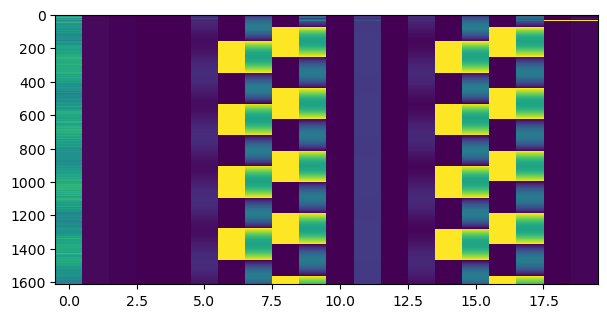

In [61]:
plt.imshow(apid1090[:, 768+63:][:, :20], aspect='auto', interpolation='none')

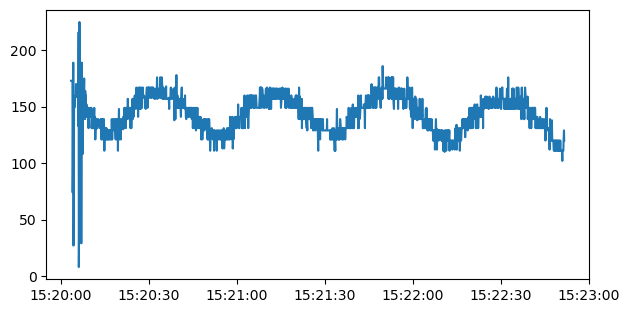

In [62]:
plt.plot(t_apid1090, apid1090[:, 768+63])
plt.gca().xaxis.set_major_formatter(date_format_sec);

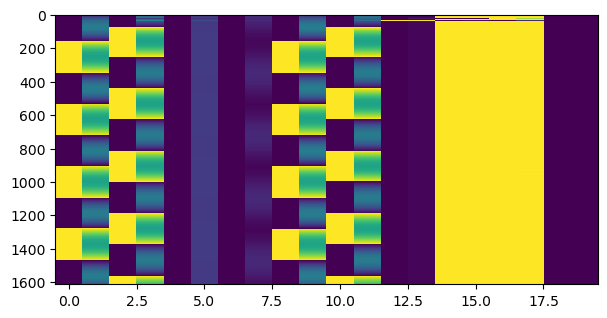

In [63]:
plt.imshow(apid1090[:, 768+63+6:][:, :20], aspect='auto', interpolation='none')

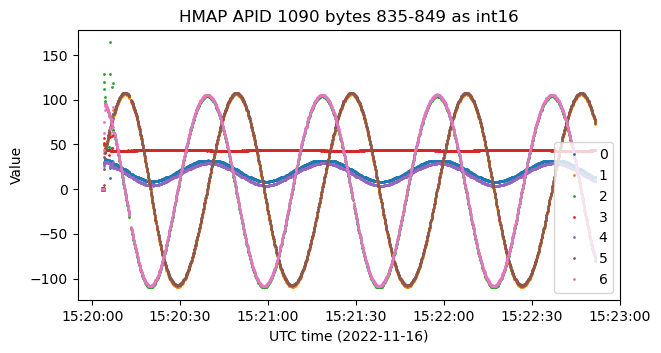

In [64]:
w = apid1090[:, 768+63+4:][:, :2*7].view('int16').byteswap()
plt.plot(t_apid1090, w, '.', markersize=2)
plt.legend([f'{j}' for j in range(w.shape[1])])
plt.title('HMAP APID 1090 bytes 835-849 as int16')
plt.ylabel('Value')
plt.xlabel('UTC time (2022-11-16)')
plt.gca().xaxis.set_major_formatter(date_format_sec);

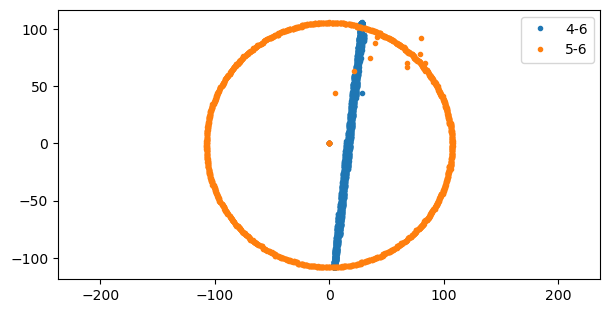

In [65]:
plt.plot(w[:, 4], w[:, 6], '.', label='4-6')
plt.plot(w[:, 5], w[:, 6], '.', label='5-6')
plt.axis('equal')
plt.legend()

## VC 63

Idle frames in VC 63 contain `0x07fe` after the AOS primary header. This is most likely an M_PDU header indicating that the packet zone contains only idle data. The packet zone is filled with `0xdc`.

In [66]:
[a for a in aos if a.virtual_channel_id == 63][:5]

[Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=504, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=505, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=506, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=507, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=508, replay_flag=False, vc_frame_count_usage_flag=

In [67]:
np.all(frames[vcid == 63, 6:8] == [0x7, 0xfe])

True

In [68]:
ccsds.M_PDU_Header.parse(frames[vcid == 63][0, 6:8])

Container(rsv_spare=0, first_header_pointer=2046)

In [69]:
np.all(frames[vcid == 63, 8:] == 0xdc)

True

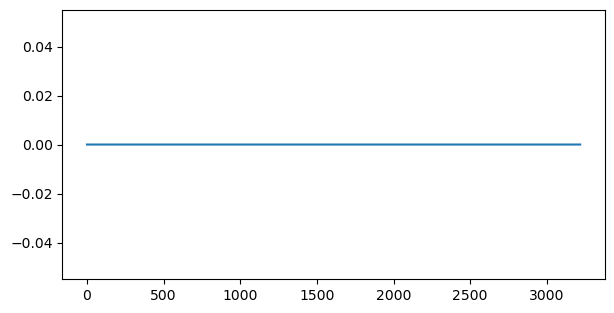

In [70]:
frame_loss_vc63 = np.diff(vcfc[vcid == 63]) - 1
plt.plot(frame_loss_vc63)

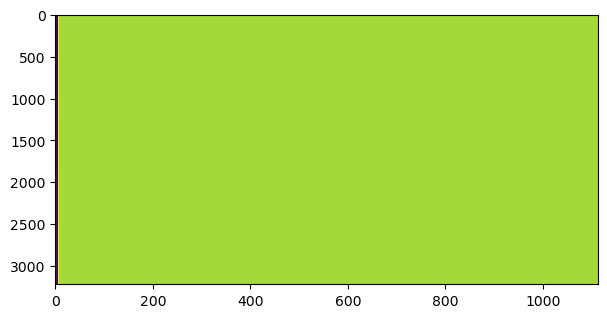

In [71]:
plt.figure()
plt.imshow(frames[vcid == 63], aspect='auto', interpolation='none')